In [1]:
%matplotlib inline
import pandas as pd
import subprocess
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
from matplotlib import colors
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from scipy.stats import norm
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV, KFold, cross_val_predict
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import cross_validation

c:\users\el-davo\appdata\local\programs\python\python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Provide the path to the file containing the data

Note I am using a third party graphing library called seaborn, website here - https://seaborn.pydata.org/. To change the background of our graphs we can use the code below

In [2]:
path_to_csv = "data/abalone.csv"       # Load Data
sns.set(rc={'figure.figsize':(11,8)})  # Change all graphs backgrounds

df = pd.read_csv(path_to_csv, header=None, names = ["Sex", "Length", "Diameter", "Height", "Whole Weight", "Shucked Weight", "Viscera Weight", "Shell Weight", "Rings"])

df.head() # Prints the first 5 rows of our dataframe

,Sex,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


# Missing Data

In [3]:
df.dtypes

Sex                object
Length            float64
Diameter          float64
Height            float64
Whole Weight      float64
Shucked Weight    float64
Viscera Weight    float64
Shell Weight      float64
Rings              object
dtype: object

Most of the columns are as we would expect. However Rings is meant to be numerical, but pandas is displaying it as an "object". This is likely a case of invalid data throwing pandas off. Using the code below we can convert all data in the row to be numeric and drop anything that isnt numeric.

In [4]:
df['Rings'] = pd.to_numeric(df['Rings'], errors='coerce')
df.dtypes

Sex                object
Length            float64
Diameter          float64
Height            float64
Whole Weight      float64
Shucked Weight    float64
Viscera Weight    float64
Shell Weight      float64
Rings             float64
dtype: object

In [5]:
nans_predicate = df.isnull().any(axis=1)
nans = df[nans_predicate]
nans

,Sex,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Rings
878,F,0.635,0.485,0.165,1.2945,0.6680,NaN,0.2715,9.0
1888,F,0.565,0.445,0.125,0.8305,0.3135,0.1785,0.2300,NaN
3093,NaN,0.520,0.430,0.150,0.7280,0.3020,0.1575,0.2350,11.0
3466,M,0.640,0.500,0.170,1.4545,0.6420,0.3575,0.3540,NaN


#### As can be seen from the results of our search we have 4 NaN rows. 

- Row 878 has an invalid Viscera weight
- row 1888 has an invalid Rings value 
- row 3093 has an invalid Sex value
- row 3466 has an invalid Rings value

We can now drop the indexes that are invalid from our dataframe. Before we do that lets display the size of our data frame before and after to confirm that the 4 rows were dropped

In [6]:
print("Before drop count", df.shape)
df.drop(df.index[nans_predicate], inplace=True)    # Drop the data with NaN values
print("After drop count", df.shape)

Before drop count (4177, 9)
After drop count (4173, 9)


# Erroneous Data

Lets now do an analysis to see if we can find any erroneous data. What I will try to do in this section is determine if the data is reasonable from a logical sense. For example abalones cannot have a height of zero, this would be impossible.

Lets start by using the describe feature of pandas to get a quick summary of the data

In [7]:
df.describe()

,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Rings
count,4173.000000,4173.000000,4173.000000,4173.000000,4173.000000,4173.000000,4173.000000,4173.000000
mean,0.523929,0.407620,0.139504,0.828504,0.359251,0.180538,0.238798,9.933621
std,0.120123,0.100111,0.041842,0.490473,0.221972,0.109625,0.139257,3.225565
min,0.075000,-0.430000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093000,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.170500,0.233500,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.501500,0.252500,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


Immediately it is odvious there are a few issues here. 

- Height cannot have a minimum value of zero
- Diameter cannot have a minimum value which is a minus number

Lets check our entire dataset for numbers which are less than or equal to zero.

In [8]:
df[(df.select_dtypes(include=['number']) <= 0).any(1)]

,Sex,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Rings
1257,I,0.430,0.34,0.000,0.4280,0.2065,0.0860,0.1150,8.0
2758,M,0.535,-0.43,0.155,0.7845,0.3285,0.1690,0.2450,10.0
3996,I,0.315,0.23,0.000,0.1340,0.0575,0.0285,0.3505,6.0


The code above has detected 3 rows containing impossible values. This could be as a result of invalid data entry or some other event, however we need to handle these entries to prevent skewed results later on.

Theres a few things we could do.

We could replace the erroneous values with the mean value of the entire column. For example in the case of the Height column we could get the mean of the Height column and replace the zero with that value.
Alternatively we can just drop the rows completely
As there are only 3 rows detected as erroneous it seems reasonable to simply drop them for now. We can do this using the code below

In [9]:
print("Before drop count", df.shape)
df.drop(df.index[df['Height'] <= 0], inplace=True)     # Drop the height erroneous rows
df.drop(df.index[df['Diameter'] <= 0], inplace=True)   # Drop the diameter erroneous rows
print("After drop count", df.shape)

Before drop count (4173, 9)
After drop count (4170, 9)


We have successfully dropped the erroneous rows, next lets make sure all values in our Sex column are upper case for consistency. We will also remove any trailing whitespace which has been put in the Sex column unintentionally

We have successfully dropped the erroneous rows. Notice above in our df.describe that there is no data on the Sex field. Lets do a few quick transformations to make sure everything is OK with this field. Lets make sure all the data in this field is uppercase and has no whitespace.

In [10]:
df['Sex'].str.upper()   # Make sure everything in the Sex column is uppercase
df['Sex'].str.strip()   # Strip whitespace from Sex column

for index, row in df.iterrows():
    if row["Sex"] != 'M' and row["Sex"] != 'F' and row["Sex"] != 'I':
        print(row["Sex"])

Everything looks ok with the Sex column.

Because shucked weight is weight without the shell. We should check if our data contains data where shucked weight is greater than the whole weight, which should not be possible.

Lets create a scatter plot of shucked weight vs whole weight for quick visual inspection

Text(0.5,1,'Shucked Weight VS Whole Weight')

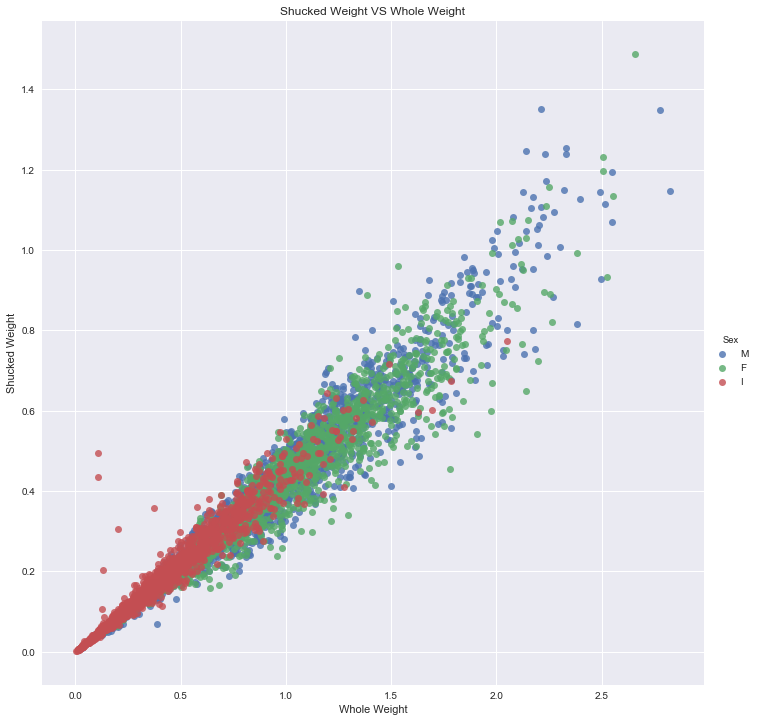

In [11]:
sns.lmplot("Whole Weight", "Shucked Weight", data=df, hue='Sex', fit_reg=False, size=10)
ax = plt.gca()
ax.set_title("Shucked Weight VS Whole Weight")

In the bottom left it seems we have some infants whose shucked weight is greater than the whole weight. 
We can get the exact rows using the formula below

In [12]:
shucked_wight_greater_than_whole = df['Shucked Weight'] > df['Whole Weight']
df[shucked_wight_greater_than_whole]

,Sex,Length,Diameter,Height,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Rings
1216,I,0.310,0.225,0.070,0.1055,0.4350,0.0150,0.0400,5.0
2627,I,0.275,0.205,0.070,0.1055,0.4950,0.0190,0.0315,5.0
2641,I,0.475,0.365,0.100,0.1315,0.2025,0.0875,0.1230,7.0
3086,I,0.355,0.270,0.075,0.2040,0.3045,0.0460,0.0595,7.0


Lets remove these rows

# Scatter Plot

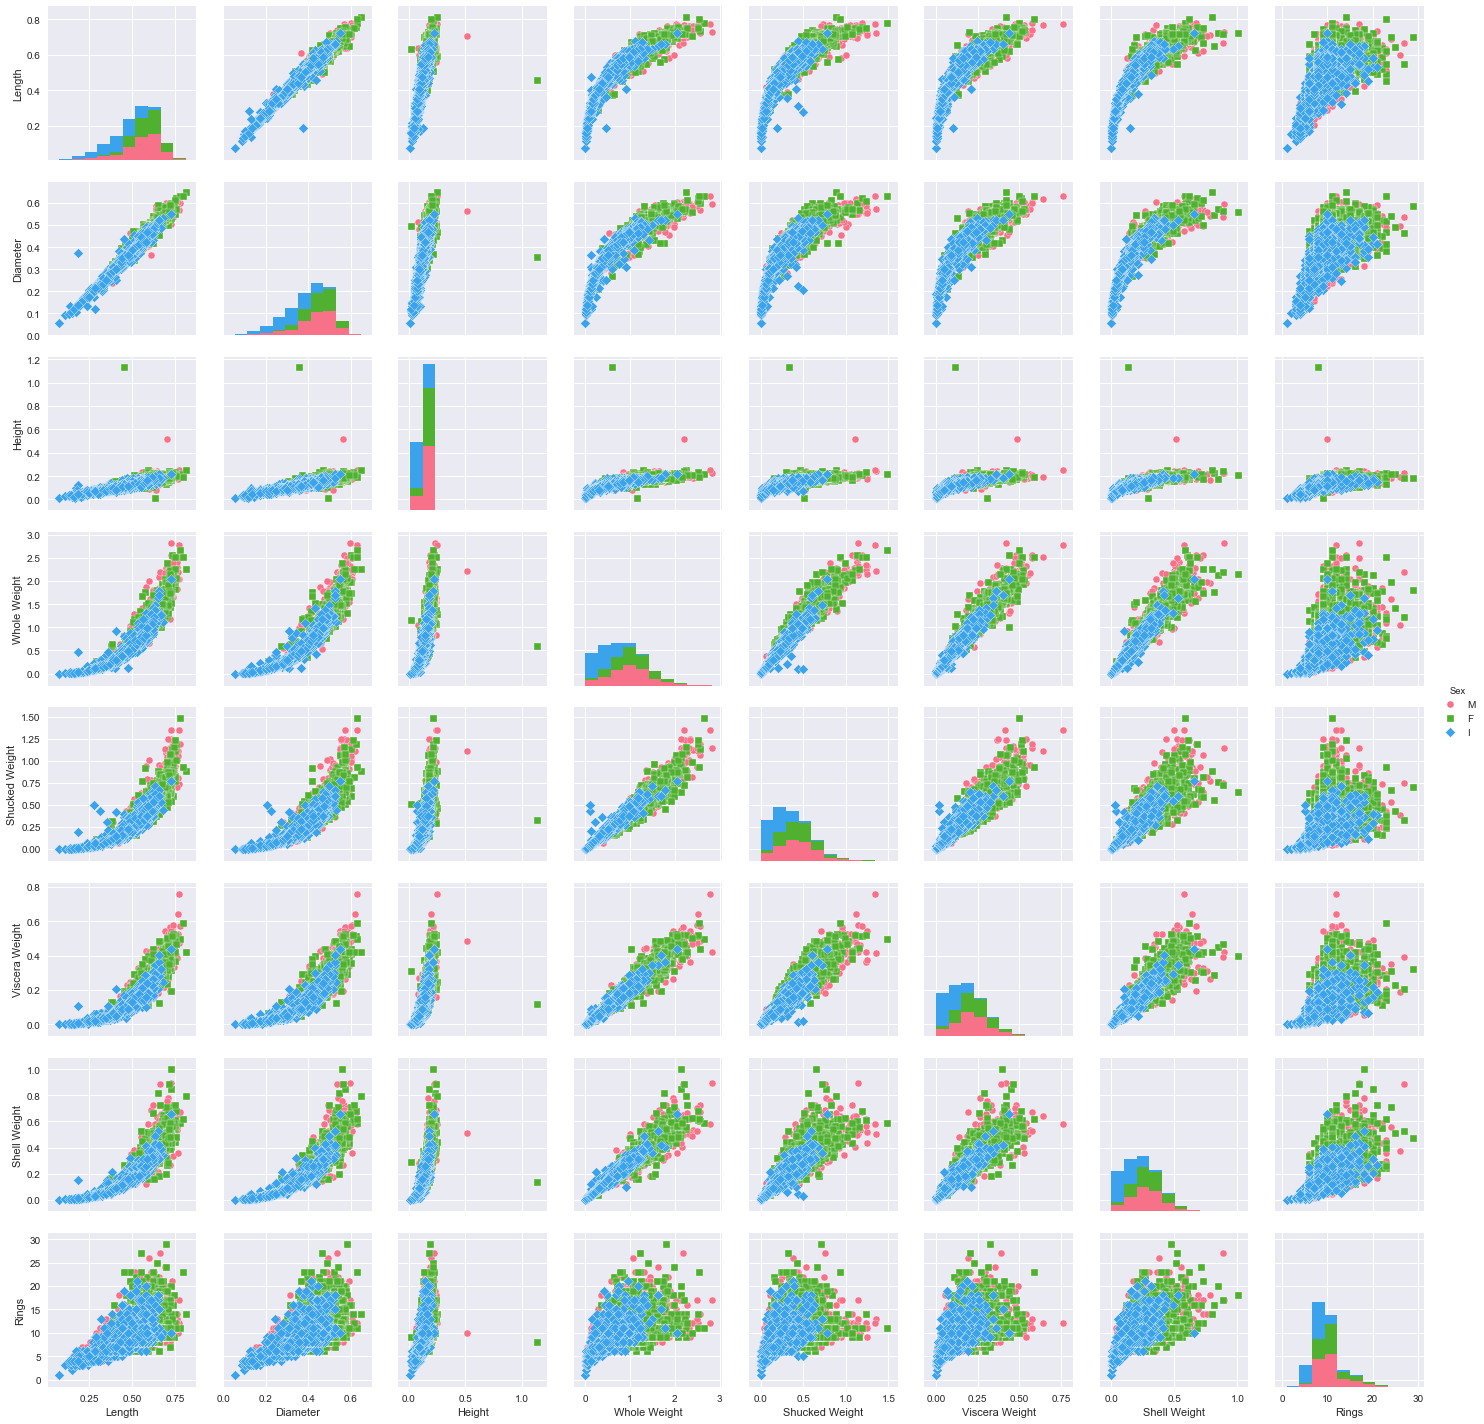

In [13]:
sns.pairplot(df, hue="Sex", palette="husl", markers=["o", "s", "D"])

There looks to be some interesting visuals here. From a quick glance it looks like we have a lot correlations. For example height, length and diameter seem highly correlated. Lets narrow our scatter plot down a bit to make this clearer 

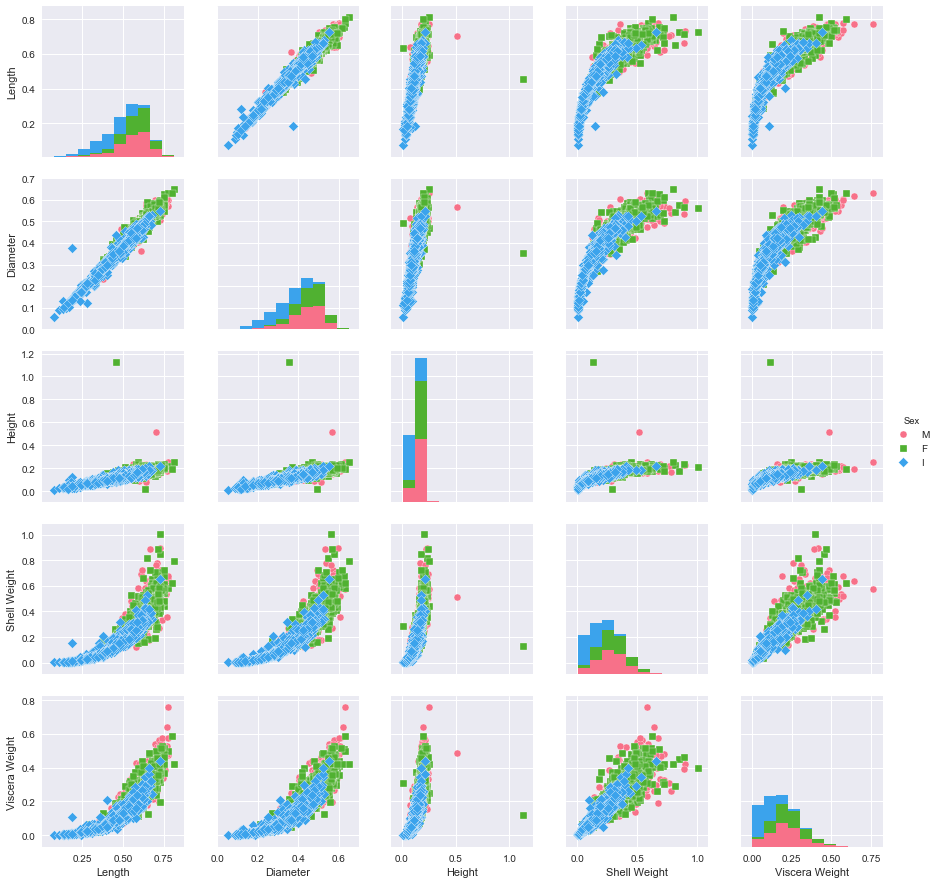

In [14]:
sns.pairplot(df[['Sex', 'Length', 'Diameter', 'Height', 'Shell Weight', 'Viscera Weight']], hue="Sex", palette="husl", markers=["o", "s", "D"])

This is a bit clearer and we can see that there are alot of correlations. Lets create a heatmap of the most correlated features and see if we can transform them into another feature.

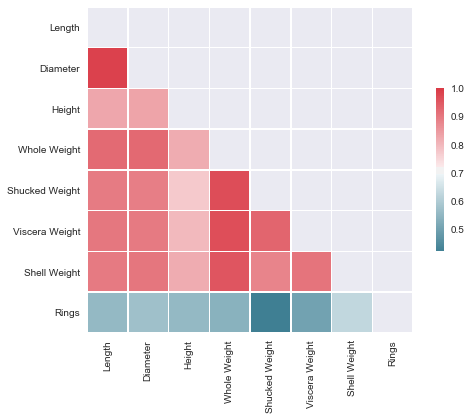

In [15]:
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(8, 6))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=ax);

Length diameter and height are very highly correlated. We can also see that whole weight and shucked weight are highly correlated. Lets use the code below to list the most highly correlated features

In [16]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(df[['Length', 'Diameter', 'Height', 'Whole Weight', 'Shucked Weight', 'Viscera Weight', 'Shell Weight', 'Rings']], 20))

Top Absolute Correlations
Length          Diameter          0.986809
Whole Weight    Shucked Weight    0.969396
                Viscera Weight    0.966350
                Shell Weight      0.955998
Shucked Weight  Viscera Weight    0.931939
Diameter        Whole Weight      0.925444
Length          Whole Weight      0.925210
Viscera Weight  Shell Weight      0.908253
Diameter        Shell Weight      0.906127
Length          Viscera Weight    0.902980
Diameter        Viscera Weight    0.899723
Length          Shell Weight      0.898466
                Shucked Weight    0.897876
Diameter        Shucked Weight    0.893182
Shucked Weight  Shell Weight      0.883264
Diameter        Height            0.834314
Length          Height            0.828138
Height          Whole Weight      0.819919
                Shell Weight      0.819603
                Viscera Weight    0.798963
dtype: float64


Again length and diameter are the most correlated. Interestingly whole weight, shucked weight, viscera weight and shell weight are also all highly correlated. 

At this stage we could think about removing some features. Length width and diameter is a good place to start. We could say that these features are the volume of the abalone. So we could create a new feature called volume

In [17]:
print(df.shape)
df.loc[:,'Volume'] = df['Length'].values * df['Diameter'].values * df['Height'].values
df = df.drop(['Length', 'Diameter', 'Height'], axis='columns')
print(df.shape)
df.head()

(4170, 9)
(4170, 7)


,Sex,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Rings,Volume
0,M,0.5140,0.2245,0.1010,0.150,15.0,0.015777
1,M,0.2255,0.0995,0.0485,0.070,7.0,0.008347
2,F,0.6770,0.2565,0.1415,0.210,9.0,0.030051
3,M,0.5160,0.2155,0.1140,0.155,10.0,0.020075
4,I,0.2050,0.0895,0.0395,0.055,7.0,0.006732


# Outliers

Here we will try and detect datapoints which are outside the normal distribution. Lets start by creating a boxplot of all the columns

Text(0.5,1,'Box Plot')

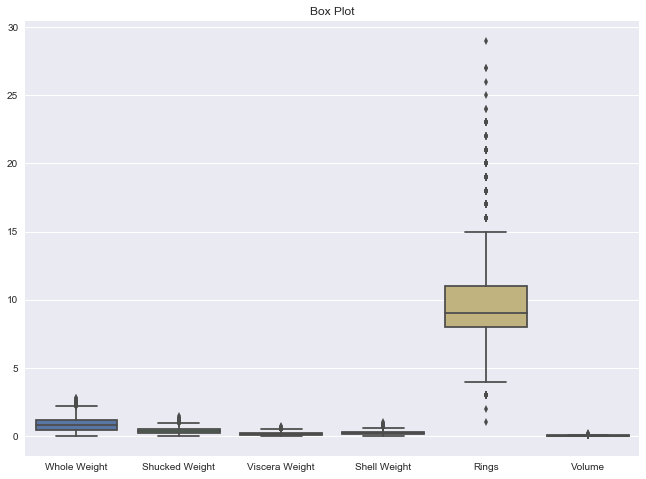

In [18]:
sns.boxplot(data=df).set_title("Box Plot")

This is slightly hard to read as the Rings column takes over much of the graph. Lets work on the Rings on its own to start with

Text(0.5,1,'Box Plot For Rings')

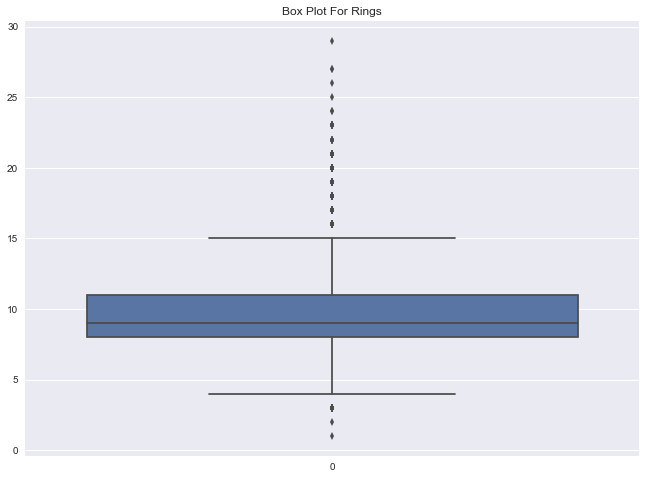

In [19]:
sns.boxplot(data=df['Rings']).set_title("Box Plot For Rings")

In [20]:
def dropOutliers(feature):
    rings = df[feature]

    q1 = rings.quantile(0.25)
    q3 = rings.quantile(0.75)
    iqr = q3 - q1
    lw = q1 - 1.5 * iqr
    uw = q3 + 1.5 * iqr
    
    outlier_predicate = (df[feature] > uw) | (df[feature] < lw)
    
    print("Lower:", lw)
    print("Upper:", uw)
    print("Total outliers:", df[outlier_predicate].count()['Rings'])
    
    df.drop(df.index[outlier_predicate], inplace=True) # Drop the rows


dropOutliers('Rings')

Lower: 3.5
Upper: 15.5
Total outliers: 278


[Text(0,0.5,'Scores'),
 Text(0.5,0,'Attributes'),
 Text(0.5,1,'Box Plot For Dataset Features without Rings')]

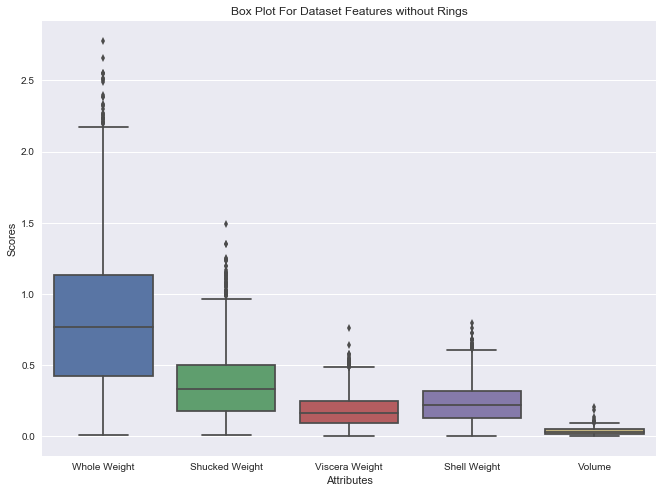

In [21]:
df_ringless=df.drop('Rings',  axis='columns')
ax=sns.boxplot(data=df_ringless)
ax.set(xlabel='Attributes', ylabel='Scores', title="Box Plot For Dataset Features without Rings")

Lets drop all the outliers for each feature

In [22]:
print('Before shape:', df.shape, '\n')
dropOutliers('Whole Weight')
dropOutliers('Shucked Weight')
dropOutliers('Viscera Weight')
dropOutliers('Shell Weight')
dropOutliers('Volume')
print('\nAfter shape:', df.shape)

Before shape: (3892, 7) 

Lower: -0.6371875
Upper: 2.1943125
Total outliers: 31
Lower: -0.29925
Upper: 0.97075
Total outliers: 20
Lower: -0.14475000000000002
Upper: 0.47725
Total outliers: 16
Lower: -0.16325
Upper: 0.59475
Total outliers: 15
Lower: -0.027478125
Upper: 0.090886875
Total outliers: 5

After shape: (3805, 7)


That should have dropped all the outliers. To be sure lets run our entire boxplot again. We should not see any outliers

Text(0.5,1,'Box Plot')

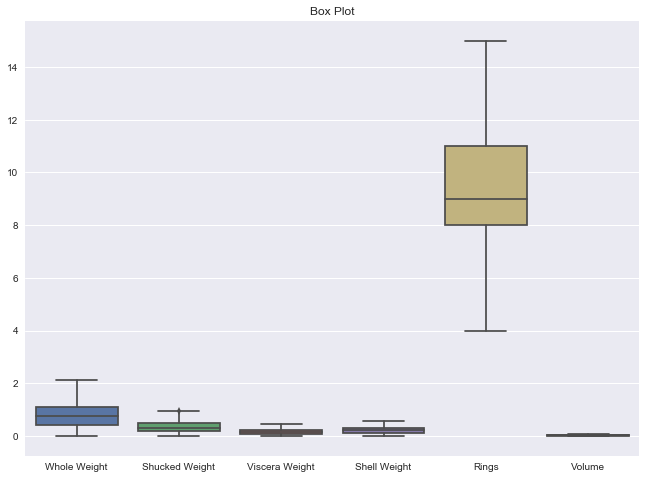

In [23]:
sns.boxplot(data=df).set_title("Box Plot")

# Linear Regression Model

Lets build a regression model for the abalone dataset. The regression model will predict the number of rings of an abalone

### One hot encoding

Because regression can only work on numeric values we are going to have to use a technique called one hot encoding to convert our Sex column into numeric data

In [24]:
print(df['Sex'].unique())

encoded_sex = pd.get_dummies(df['Sex'])
df = pd.concat([df, encoded_sex], axis='columns')
df = df.drop('Sex', axis='columns')

df.head()

['M' 'F' 'I']


,Whole Weight,Shucked Weight,Viscera Weight,Shell Weight,Rings,Volume,F,I,M
0,0.5140,0.2245,0.1010,0.150,15.0,0.015777,0,0,1
1,0.2255,0.0995,0.0485,0.070,7.0,0.008347,0,0,1
2,0.6770,0.2565,0.1415,0.210,9.0,0.030051,1,0,0
3,0.5160,0.2155,0.1140,0.155,10.0,0.020075,0,0,1
4,0.2050,0.0895,0.0395,0.055,7.0,0.006732,0,1,0


0.4925933506048734
Root mean squared error 1.6938600288891759


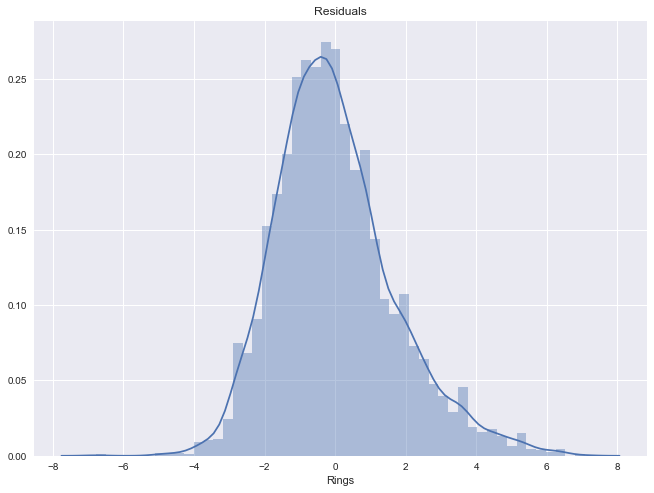

In [25]:
X = df.drop(['Rings'], axis='columns')  # X = features
y = df['Rings']                       # y = prediction target

lmreg = LinearRegression()

lmreg.fit(X, y)

yhat = lmreg.predict(X)
lmresid = y - yhat
sns.distplot(lmresid)
plt.title('Residuals')

print(lmreg.score(X, y))

rmse = np.mean((yhat - y) ** 2)**.5

mean = df['Rings'].mean()
var = np.sqrt(df['Rings'].var())
print("Root mean squared error", rmse)

plt.show()

According to this report our linear model will be right 49% of the time. This isnt great. It would be like tossing a coin. Lets see if we can do better. Lets see if we can do better by splitting into diffferent Sexes. 

Text(15,3,'Root Mean Square Error = 1.694')

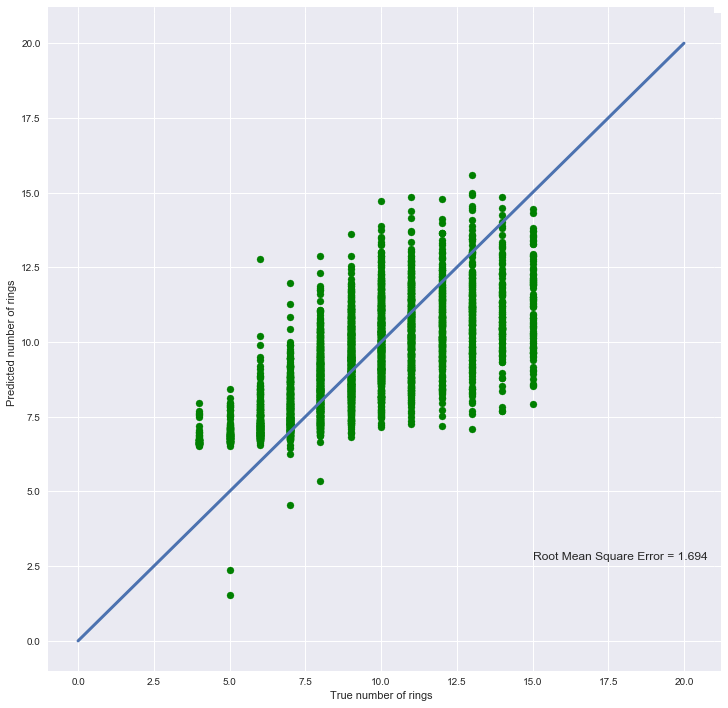

In [26]:
grid  = sns.JointGrid(y, yhat, space=0, size=10, ratio=100)
ax = grid.plot_joint(plt.scatter, color="g")
plt.plot([0, 20], [0, 20], linewidth=3)

plt.xlabel('True number of rings')
plt.ylabel('Predicted number of rings')
plt.text(15, 3,"Root Mean Square Error = %.4g" % rmse, ha='left', va='top')

Total Males: 1357
Total Females: 1147
Only Males:  0.35200742200394686
Only Females:  0.24626133034316297
Only Infants:  0.5570799656025012


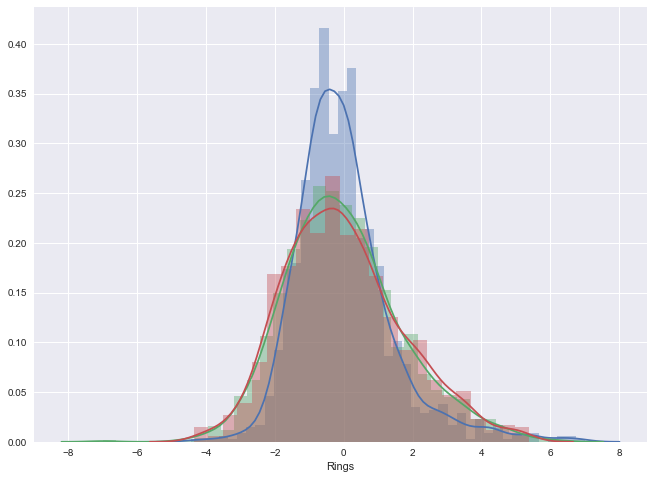

In [27]:
males = df[df['M'] == 1];
females = df[df['F'] == 1];
infants = df[df['I'] == 1];

print('Total Males:', males.shape[0]);
print('Total Females:', females.shape[0]);

males_X = males.drop(['Rings'], axis='columns')  # X = features
males_y = males['Rings']                       # y = prediction target

females_X = females.drop(['Rings'], axis='columns')  # X = features
females_y = females['Rings']                       # y = prediction target

infants_X = infants.drop(['Rings'], axis='columns')  # X = features
infants_y = infants['Rings']                       # y = prediction target

male_lmreg = LinearRegression( fit_intercept = False )
female_lmreg = LinearRegression( fit_intercept = False )
infants_lmreg = LinearRegression( fit_intercept = False )

male_lmreg.fit(males_X, males_y)
male_yhat = male_lmreg.predict(males_X)
male_lmresid = males_y - male_yhat

female_lmreg.fit(females_X, females_y)
female_yhat = female_lmreg.predict(females_X)
female_lmresid = females_y - female_yhat

infants_lmreg.fit(infants_X, infants_y)
infants_yhat = infants_lmreg.predict(infants_X)
infants_lmresid = infants_y - infants_yhat

print('Only Males: ', male_lmreg.score(males_X, males_y))
print('Only Females: ', female_lmreg.score(females_X, females_y))
print('Only Infants: ', infants_lmreg.score(infants_X, infants_y))

sns.distplot(infants_lmresid)
sns.distplot(male_lmresid)
sns.distplot(female_lmresid)

plt.show()

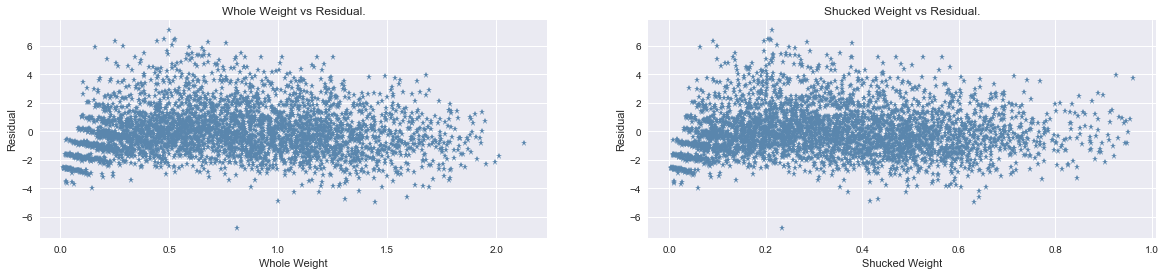

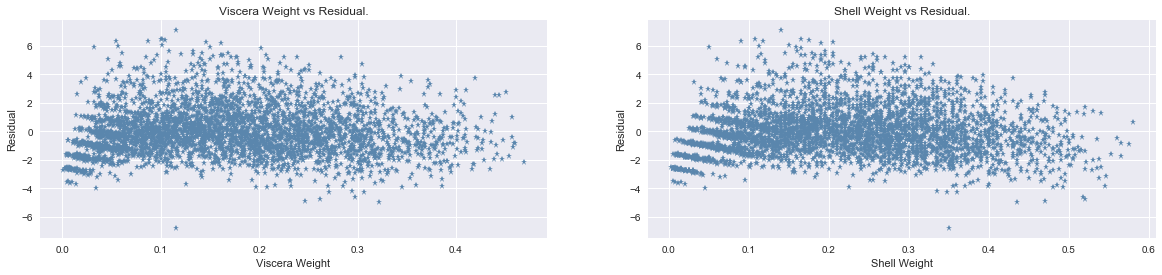

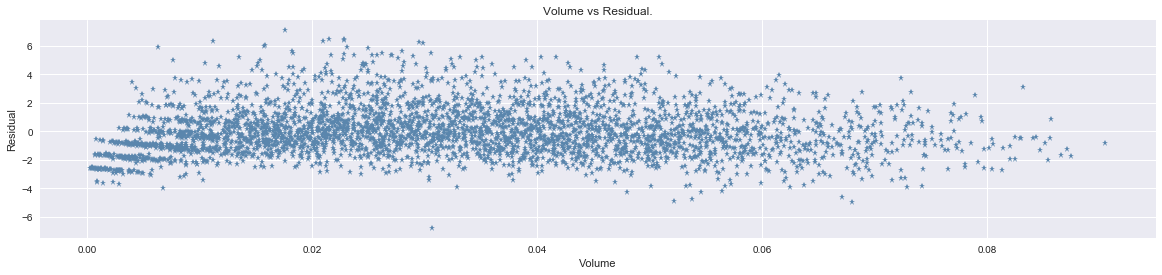

In [28]:
fig_row_1, (ax1, ax2) = plt.subplots(1,2,figsize=(20,4))
fig_row_2, (ax3, ax4) = plt.subplots(1,2,figsize=(20,4))
fig_row_3, (ax5) = plt.subplots(1,1,figsize=(20,4))

def plotResiduals(resid, ax, column):
    ax.plot(df[column], resid, '*', color=sns.xkcd_rgb['dusty blue'])
    ax.set_xlabel(column)
    ax.set_ylabel('Residual')
    ax.set_title("%s vs Residual." % (column))
    
plotResiduals(lmresid, ax1, 'Whole Weight')
plotResiduals(lmresid, ax2, 'Shucked Weight')
plotResiduals(lmresid, ax3, 'Viscera Weight')
plotResiduals(lmresid, ax4, 'Shell Weight')
plotResiduals(lmresid, ax5, 'Volume')

plt.show()

# Lasso Regression

In [29]:
lass = LassoCV(random_state=0)
lass = lass.fit(X, y)

print(lass.score(X, y))

0.49180849825153256


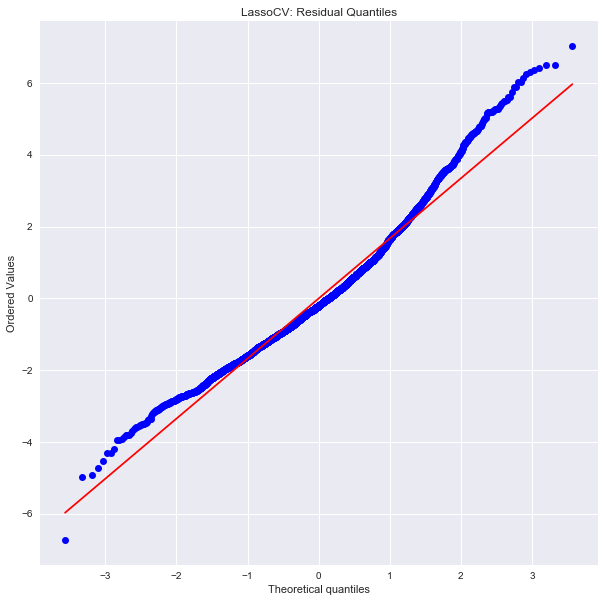

In [30]:
lassyhat = lass.predict(X)
lassy = df['Rings']
lassresid = lassy - lassyhat

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111)

stats.probplot(lassresid, dist='norm', plot=ax1)

ax1.set_title('LassoCV: Residual Quantiles')

plt.show()

Text(65.125,0.5,'Predicted number of rings')

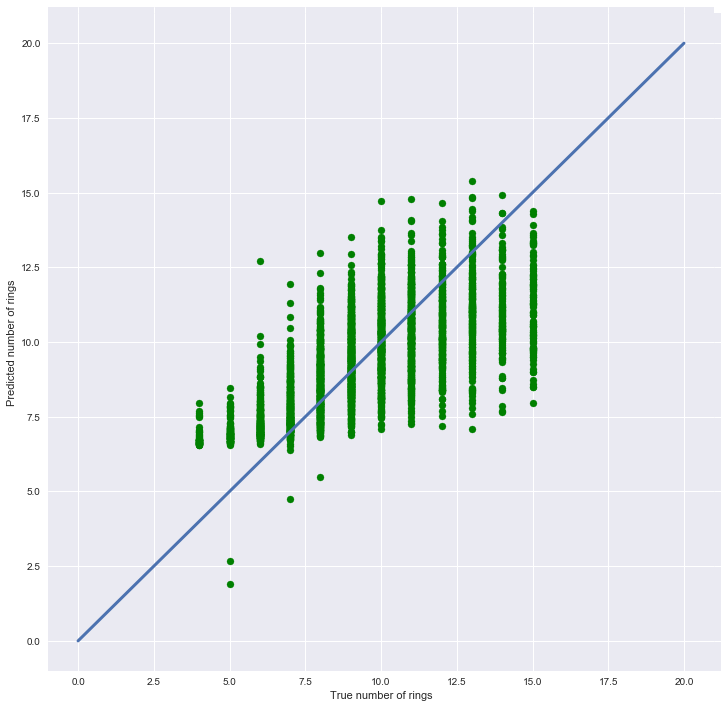

In [31]:
grid  = sns.JointGrid(y, lassyhat, space=0, size=10, ratio=100)
ax = grid.plot_joint(plt.scatter, color="g")
plt.plot([0, 20], [0, 20], linewidth=3)

plt.xlabel('True number of rings')
plt.ylabel('Predicted number of rings')

# Decision Tree Regression

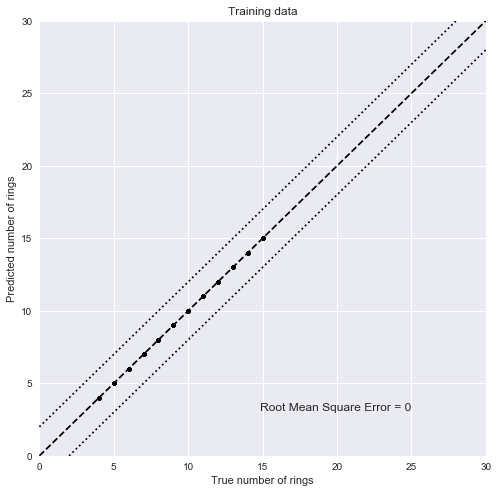

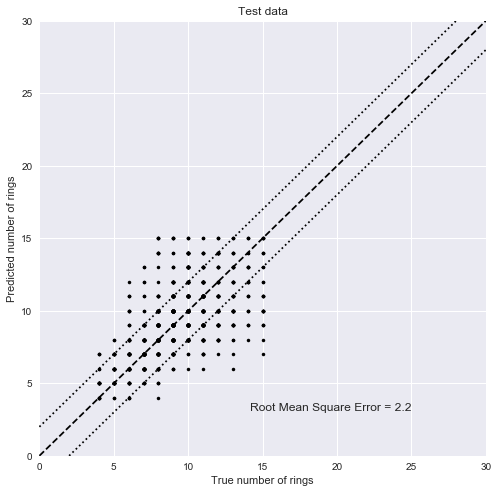

In [32]:
X = df.drop('Rings', axis='columns')  # X = features
y = df['Rings']                       # y = prediction target

train_X, test_X, train_y, test_y = cross_validation.train_test_split(X, y) # splits 75%/25% by default
# create an estimator, optionally specifying parameters
model = DecisionTreeRegressor()
# fit the estimator to the data
model.fit(train_X, train_y)
# apply the model to the test and training data
predicted_test_y = model.predict(test_X)
predicted_train_y = model.predict(train_X)

def scatter_y(true_y, predicted_y):
    """Scatter-plot the predicted vs true number of rings
    
    Plots:
       * predicted vs true number of rings
       * perfect agreement line
       * +2/-2 number dotted lines

    Returns the root mean square of the error
    """
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(true_y, predicted_y, '.k')
    
    ax.plot([0, 30], [0, 30], '--k')
    ax.plot([0, 30], [2, 32], ':k')
    ax.plot([2, 32], [0, 30], ':k')
    
    rms = (true_y - predicted_y).std()
    
    ax.text(25, 3,
            "Root Mean Square Error = %.2g" % rms,
            ha='right', va='bottom')

    ax.set_xlim(0, 30)
    ax.set_ylim(0, 30)
    
    ax.set_xlabel('True number of rings')
    ax.set_ylabel('Predicted number of rings')
    
    return rms


scatter_y(train_y, predicted_train_y)
plt.title("Training data")
scatter_y(test_y, predicted_test_y)
plt.title("Test data");

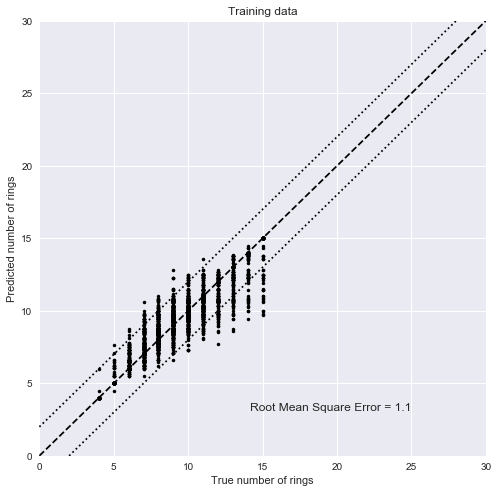

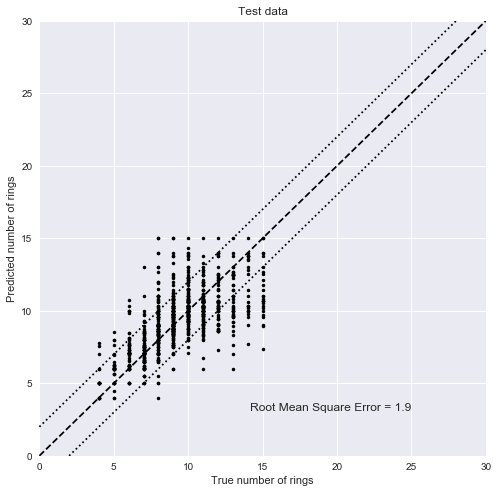

In [33]:
model = DecisionTreeRegressor(max_depth=10)
# fit the estimator to the data
model.fit(train_X, train_y)
# apply the model to the test and train data
predicted_test_y = model.predict(test_X)
predicted_train_y = model.predict(train_X)
scatter_y(train_y, predicted_train_y)
plt.title("Training data")
rms_decision_tree = scatter_y(test_y, predicted_test_y)
plt.title("Test data");

In [34]:
X = df.drop(['Rings'], axis='columns')  # X = features
y = df['Rings']                       # y = prediction target

dt= DecisionTreeClassifier(random_state=0, criterion='gini', min_samples_split=200, min_samples_leaf=82)

dt.fit(X, y)
    
pipeline = make_pipeline(
    dt
)

parameters = {
    'decisiontreeclassifier__criterion': ['gini', 'entropy']
}

inner_cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=0)  # K = 5

clf = GridSearchCV(pipeline, parameters, cv=inner_cv, n_jobs=-1)  # n_jobs=-1 uses all available CPUs = faster
clf.fit(X, y)

# Use outer CV to evaluate the error of the best model
outer_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)  # K = 10, doesn't have to be the same
y_pred = cross_val_predict(clf, X, y, cv=outer_cv)

print(classification_report(y, y_pred))  # Print the classification report

# Print the results 
print('Mean absolute error: %f' % mean_absolute_error(y, y_pred))
print('Standard deviation of the error: %f' % (y - y_pred).std())

             precision    recall  f1-score   support

        4.0       0.49      0.39      0.43        57
        5.0       0.34      0.29      0.31       115
        6.0       0.32      0.31      0.31       258
        7.0       0.35      0.32      0.34       391
        8.0       0.33      0.39      0.36       566
        9.0       0.27      0.37      0.31       684
       10.0       0.26      0.36      0.30       619
       11.0       0.31      0.23      0.27       459
       12.0       0.21      0.06      0.09       245
       13.0       0.17      0.15      0.16       194
       14.0       0.10      0.03      0.04       117
       15.0       0.00      0.00      0.00       100

avg / total       0.28      0.29      0.28      3805

Mean absolute error: 1.279369
Standard deviation of the error: 1.775253


c:\users\el-davo\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [35]:
'''
def svc_param_selection(X, y, nfolds):
    param_grid = {'decisiontreeclassifier__criterion': ['gini', 'entropy'],
                 'decisiontreeclassifier__min_samples_split':range(2,2000,10),
                 #'decisiontreeclassifier__min_samples_leaf': range(2,200,10),
                 #'decisiontreeclassifier__max_leaf_nodes': range(2,200,10),
                 'decisiontreeclassifier__min_impurity_split': range(2,2000,5),
                 'decisiontreeclassifier__random_state': range(2,2000,5)
                 }
    grid_search = GridSearchCV(pipeline, param_grid, n_jobs=-1, cv=nfolds)  # n_jobs=-1 uses all available CPUs = faster
    grid_search.fit(X, y)
    grid_search.best_params_
    return {'bestParams': grid_search.best_params_, 'bestScore': grid_search.best_score_}

print(svc_param_selection(X, y, inner_cv))
'''

"\ndef svc_param_selection(X, y, nfolds):\n    param_grid = {'decisiontreeclassifier__criterion': ['gini', 'entropy'],\n                 'decisiontreeclassifier__min_samples_split':range(2,2000,10),\n                 #'decisiontreeclassifier__min_samples_leaf': range(2,200,10),\n                 #'decisiontreeclassifier__max_leaf_nodes': range(2,200,10),\n                 'decisiontreeclassifier__min_impurity_split': range(2,2000,5),\n                 'decisiontreeclassifier__random_state': range(2,2000,5)\n                 }\n    grid_search = GridSearchCV(pipeline, param_grid, n_jobs=-1, cv=nfolds)  # n_jobs=-1 uses all available CPUs = faster\n    grid_search.fit(X, y)\n    grid_search.best_params_\n    return {'bestParams': grid_search.best_params_, 'bestScore': grid_search.best_score_}\n\nprint(svc_param_selection(X, y, inner_cv))\n"